During the test on 8/27/24 I noticed there are changes in lat, lon position that appear to be 'jumps' that are beyond the physical limits of the tractor.  The RTK status is 2 so these changes are unexpected.  I need to calculate the acceleration required between lat, lon data points, calculate the g forces those changes would correlate to and somehow filter the changes similar to what I did with speed data for the left and right speed sensors.  In this case not only will I have to track the speed, but also the heading and calculate a likely position instead of the anomolous one.

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


ValueError: x and y must have same first dimension, but have shapes (1881,) and (1880,)

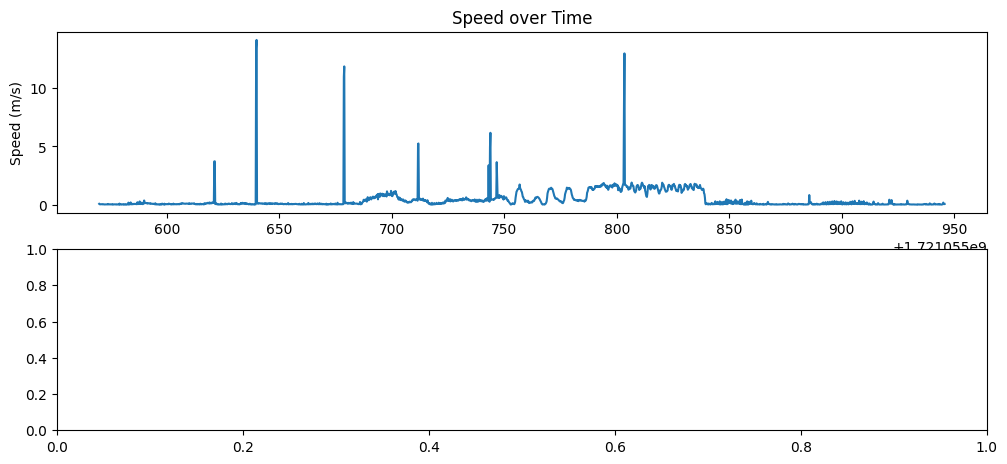

In [2]:
import sys
sys.path.append('/opt/ros/noetic/lib/python3/dist-packages')
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from geopy import distance
from datetime import datetime

# Function to calculate acceleration
def calculate_acceleration(speeds, times):
    accelerations = np.diff(speeds) / np.diff(times)
    return np.insert(accelerations, 0, 0)  # Insert 0 at the beginning to match array sizes

# Path to your rosbag file
bag_file = '/home/tractor/bagfiles/2024-07-15-10-59-29.bag'

# Lists to store data
timestamps = []
latitudes = []
longitudes = []

# Open the rosbag file
with rosbag.Bag(bag_file, 'r') as bag:
    for topic, msg, t in bag.read_messages(topics=['/fix']):  # Adjust topic if needed
        timestamps.append(t.to_sec())
        latitudes.append(msg.latitude)
        longitudes.append(msg.longitude)

# Convert to numpy arrays
timestamps = np.array(timestamps)
latitudes = np.array(latitudes)
longitudes = np.array(longitudes)

# Calculate time differences
time_diffs = np.diff(timestamps)

# Calculate distances between consecutive points
distances = []
for i in range(len(latitudes) - 1):
    dist = distance.distance((latitudes[i], longitudes[i]), 
                             (latitudes[i+1], longitudes[i+1])).meters
    distances.append(dist)

distances = np.array(distances)

# Calculate speeds (m/s)
speeds = distances / time_diffs

# Calculate accelerations (m/s^2)
accelerations = calculate_acceleration(speeds, time_diffs)

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(timestamps[1:], speeds)
plt.title('Speed over Time')
plt.ylabel('Speed (m/s)')

plt.subplot(3, 1, 2)
plt.plot(timestamps[1:], accelerations[1:])
plt.title('Acceleration over Time')
plt.ylabel('Acceleration (m/s^2)')

plt.subplot(3, 1, 3)
plt.plot(longitudes, latitudes)
plt.title('GPS Track')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Find anomalies (e.g., accelerations > 2 m/s^2 or < -2 m/s^2)
anomalies = np.where((accelerations > 2) | (accelerations < -2))[0]

print("Anomalies detected at indices:", anomalies)
for idx in anomalies:
    print(f"Anomaly at {datetime.fromtimestamp(timestamps[idx])}: "
          f"Acceleration = {accelerations[idx]:.2f} m/s^2, "
          f"Speed = {speeds[idx]:.2f} m/s, "
          f"Lat = {latitudes[idx]}, Lon = {longitudes[idx]}")